In [1]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [2]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [4]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [6]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

#Read Dataset

In [7]:
#@title Read dataset
df_o = pd.read_csv(path+'application_train.csv')    #HomeCredit training dataset

In [8]:
#@title Create develoment train and test
df_train, df_test = tr.create_train_test(df_o, seed=43)

In [9]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 5555

main_seed = seed_number

print(seed_number)

5555


#Params

In [10]:
params_dict = ri.params_dict

In [11]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

#<font color='orange'>Helper Functions</font>


#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [12]:
N_splits=5
kf = KFold(n_splits=N_splits)   #80-20 split for train-test
hist_dict = {}
data_dict = {}

for fold_number, (train_index, test_index) in enumerate(kf.split(df_o)):
    #diferent seed for each iteration
    seed_number = main_seed+fold_number

    df_train = df_o.iloc[train_index]
    df_test = df_o.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    df_train, policy_model = ri.fit_policy(df_train)

    X_train, X_test, X_val = df_train, df_test, df_val
    y_train, y_test, y_val = df_train["TARGET"], df_test["TARGET"], df_val["TARGET"]

    X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model)
    X_test_acp, X_test_rej, y_test_acp, y_test_rej = ri.accept_reject_split(X_test, y_test, policy_clf=policy_model)
    X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model)
    
    data_dict[fold_number] = [X_train_acp, X_train_rej, y_train_acp, y_train_rej,
                               X_test_acp, X_test_rej, y_test_acp,
                               X_val_acp, X_val_rej, y_val_acp]
    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    # break
    models_dict = {}

    benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                  LGBMClassifier(**params_dict['LightGBM_2']))
    benchmark.fit(X_train_acp, y_train_acp)

    
    models_dict['BM'] = benchmark

    # models_dict.update(
    #     ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    # models_dict.update(
    #     ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    # models_dict.update(
    #     ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
                                 X_val_acp, y_val_acp, iterations=3,p = 0.07, output=-1,
                                 seed=seed_number, technique='LS'))
    
    hist_dict[fold_number] = models_dict
    # metrics_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    print(fold_number)
    # break

0
1
2
3
4


In [13]:
# main_seed = 7777
seed_number = main_seed

In [14]:
for fold_number in range(N_splits):
    print(seed_number+fold_number)

5555
5556
5557
5558
5559


In [16]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    seed_number = main_seed+fold_number
    filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
    datasets = joblib.load(filepath)


    values = ri.get_metrics_RI(datasets, X_val_acp, y_val_acp, X_unl = X_test_rej, threshold_type='none', 
                            acp_rate=0.05).loc[
                                ["Overall AUC", "Kickout"]].T.to_numpy()
    weights = [10,1]
    criterias = np.array([True, True])
    t = top.Topsis(values, weights, criterias)
    t.calc()
    output = t.rank_to_best_similarity()[0] - 1
    print(f'best iteration: {output}')
    if output != 0:
        hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
    else:
        hist_dict[fold_number]['TN'] = datasets['BM']
    # break

best iteration: 1
best iteration: 0
best iteration: 3
best iteration: 3
best iteration: 3


In [17]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.8)
    # break
mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

    

,BM,E-C,LSP,TN
Overall AUC,0.723714,0.719875,0.714254,0.722390
KS,0.332597,0.330676,0.324543,0.331909
Balanced Accuracy,0.661032,0.656293,0.653754,0.660765
Accuracy,0.702372,0.631125,0.663273,0.672391
Precision,0.097385,0.087113,0.089588,0.092974
Recall,0.615265,0.684054,0.643232,0.647781
F1,0.167819,0.153912,0.156822,0.162066
Approval Rate,0.937560,0.939397,0.932209,0.936718
Kickout,0.000000,-0.084413,0.036651,0.280831
KG,0.000000,88.400000,318.600000,93.200000


In [ ]:
metrics_dict[0]

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.728760,0.718178,0.726492,0.729312,0.707245,0.726238,0.728616,0.718418,0.708055
KS,0.329752,0.333933,0.340996,0.346212,0.311606,0.332895,0.329789,0.333650,0.324308
Balanced Accuracy,0.659920,0.658317,0.669198,0.672342,0.642869,0.664617,0.656946,0.661194,0.654431
Accuracy,0.628453,0.715071,0.660834,0.685237,0.736055,0.693886,0.689126,0.645615,0.578707
Precision,0.087509,0.099544,0.093591,0.098031,0.099124,0.097479,0.094704,0.089762,0.081700
Recall,0.694823,0.595368,0.678474,0.658038,0.539510,0.632153,0.621253,0.678474,0.738420
F1,0.155440,0.170570,0.164492,0.170641,0.167477,0.168912,0.164354,0.158548,0.147123
Approval Rate,0.888576,0.890788,0.884151,0.897493,0.869938,0.906610,0.904666,0.904063,0.905001
Kickout,0.000000,1.145364,-0.021137,0.455234,-0.210967,0.063609,-0.145763,0.419741,-0.224128
KG,0.000000,443.000000,93.000000,126.000000,149.000000,68.000000,43.000000,310.000000,847.000000


In [18]:
metric = mean_metrics.loc[['Overall AUC', 'Kickout', 'Approval Rate']]

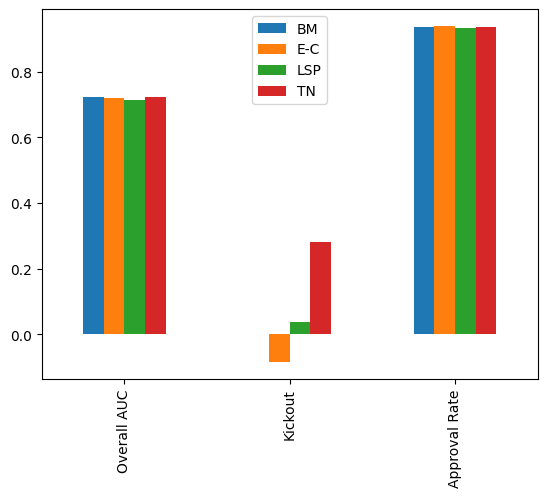

In [19]:
metric.plot.bar()
plt.show()

In [ ]:
metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.8)

In [ ]:
cols = ['Overall AUC','Kickout',]

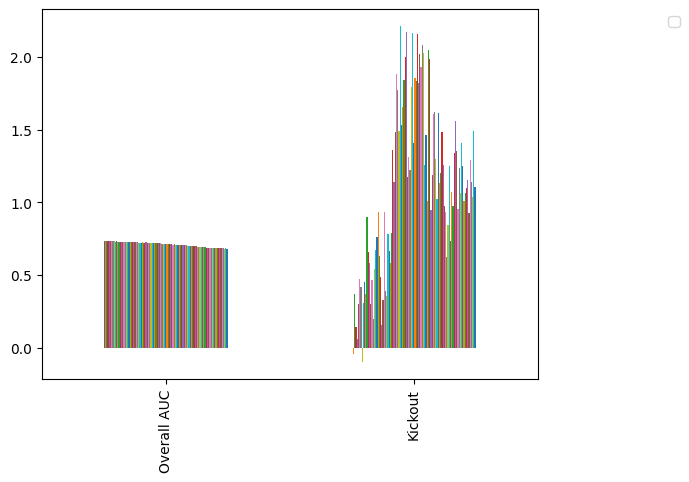

In [ ]:
metrics.loc[cols].plot.bar().legend([], loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

In [ ]:
metrics

,BM,TN_1,TN_2,TN_3,TN_4,TN_5,TN_6,TN_7,TN_8,TN_9,...,TN_91,TN_92,TN_93,TN_94,TN_95,TN_96,TN_97,TN_98,TN_99,TN_100
Overall AUC,0.734145,0.732371,0.733630,0.734031,0.732997,0.733233,0.732250,0.732088,0.731635,0.730550,...,0.685974,0.684288,0.684491,0.684227,0.683504,0.684002,0.684455,0.682334,0.683261,0.682512
KS,0.363917,0.363790,0.361959,0.362925,0.355804,0.358316,0.358509,0.357602,0.356786,0.355502,...,0.278044,0.273720,0.276618,0.268338,0.273548,0.273082,0.275404,0.272680,0.270257,0.267752
Balanced Accuracy,0.674595,0.680442,0.673596,0.671954,0.671723,0.674429,0.673554,0.677273,0.675791,0.674004,...,0.629218,0.636000,0.621607,0.628695,0.630952,0.633079,0.636683,0.625748,0.626845,0.628079
Accuracy,0.688839,0.703720,0.713103,0.726173,0.734455,0.673568,0.675639,0.708897,0.694856,0.675251,...,0.658428,0.701262,0.596571,0.678615,0.685409,0.667033,0.721255,0.609447,0.638952,0.697379
Precision,0.095040,0.099084,0.099070,0.101251,0.102986,0.092642,0.092740,0.099235,0.096337,0.092789,...,0.080074,0.087049,0.073156,0.082184,0.083585,0.081930,0.090368,0.074940,0.077633,0.084386
Recall,0.658872,0.654746,0.629986,0.612105,0.602476,0.675378,0.671252,0.642366,0.654746,0.672627,...,0.596974,0.563961,0.649243,0.573590,0.570839,0.595598,0.543329,0.643741,0.613480,0.551582
F1,0.166118,0.172121,0.171215,0.173760,0.175904,0.162933,0.162965,0.171912,0.167960,0.163082,...,0.141207,0.150818,0.131495,0.143768,0.145819,0.144045,0.154963,0.134251,0.137824,0.146377
Approval Rate,0.953995,0.952313,0.952572,0.950631,0.954772,0.946166,0.950243,0.952831,0.945196,0.950243,...,0.926043,0.928179,0.924490,0.925461,0.926367,0.920349,0.919055,0.917179,0.913750,0.914267
Kickout,0.000000,-0.042665,0.372498,0.145225,0.063177,0.300295,0.475057,0.415983,-0.097637,0.310962,...,1.007548,1.066623,1.096160,1.152773,0.928782,1.291434,1.142927,1.037906,1.489170,1.103544
KG,0.000000,13.000000,25.000000,25.000000,50.000000,47.000000,63.000000,81.000000,99.000000,113.000000,...,1632.000000,1614.000000,1605.000000,1657.000000,1656.000000,1684.000000,1660.000000,1692.000000,1693.000000,1672.000000


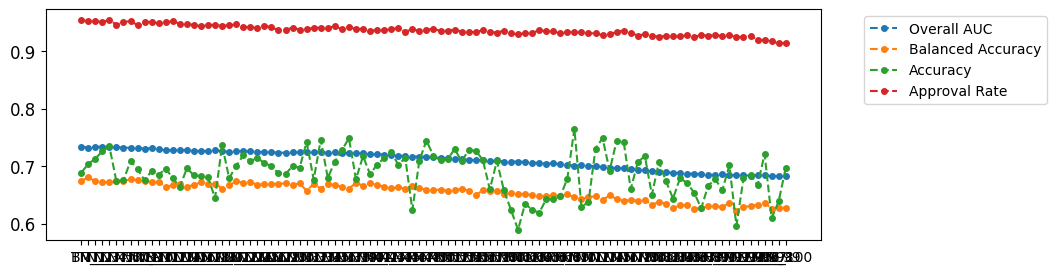

In [ ]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

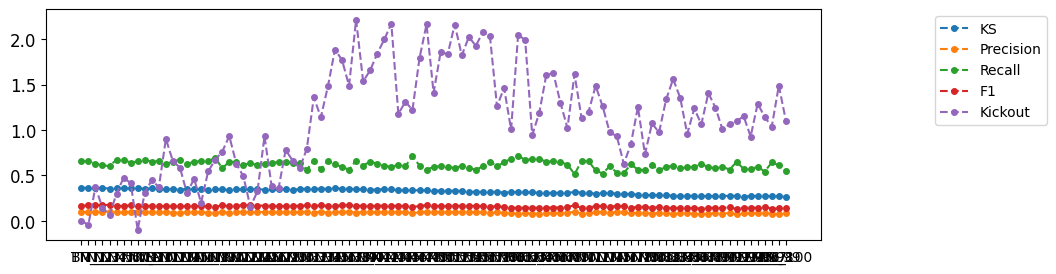

In [ ]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()